# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 13 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=6,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        w=self.scaleLayer(w)
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.37:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.328354, Accuracy: 10.16
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.338634, Accuracy: 9.77
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.267911, Accuracy: 16.41
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.113000, Accuracy: 19.53
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.125578, Accuracy: 17.58
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.039315, Accuracy: 18.75
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.050020, Accuracy: 20.31
Train Epoch: 0 [8960/50000 (20%)]	Loss: 1.969087, Accuracy: 19.92
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.015139, Accuracy: 20.31
Train Epoch: 0 [11520/50000 (26%)]	Loss: 2.046043, Accuracy: 21.09
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.929736, Accuracy: 23.44
Train Epoch: 0 [14080/50000 (31%)]	Loss: 1.959039, Accuracy: 19.14
Train Epoch: 0 [15360/50000 (34%)]	Loss: 2.042078, Accuracy: 22.27
Train Epoch: 0 [16640/50000 (37%)]	Loss: 2.044830, Accuracy: 21.09
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.895948, Accuracy: 26.56
Train Epoch

Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.008985, Accuracy: 62.50
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.056016, Accuracy: 61.33
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.055007, Accuracy: 63.28
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.080512, Accuracy: 62.11
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.056640, Accuracy: 63.28
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.083288, Accuracy: 60.94
Train Epoch: 3 [21760/50000 (48%)]	Loss: 1.117985, Accuracy: 58.59
Train Epoch: 3 [23040/50000 (51%)]	Loss: 1.001983, Accuracy: 64.06
Train Epoch: 3 [24320/50000 (54%)]	Loss: 1.108540, Accuracy: 61.33
Train Epoch: 3 [25600/50000 (57%)]	Loss: 0.954309, Accuracy: 67.19
Train Epoch: 3 [26880/50000 (60%)]	Loss: 1.093972, Accuracy: 60.94
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.107895, Accuracy: 59.77
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.084797, Accuracy: 62.89
Train Epoch: 3 [30720/50000 (68%)]	Loss: 1.028764, Accuracy: 64.06
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.157622, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.837165, Accuracy: 69.92
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.700612, Accuracy: 75.78
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.753995, Accuracy: 76.95
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.770776, Accuracy: 71.88
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.727838, Accuracy: 74.22
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.758191, Accuracy: 76.17
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.747737, Accuracy: 75.78
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.742901, Accuracy: 73.83
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.764363, Accuracy: 70.70
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.808656, Accuracy: 71.48
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.772655, Accuracy: 73.44
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.683324, Accuracy: 76.95
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.790696, Accuracy: 71.88
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.830102, Accuracy: 67.97
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.800624, Accuracy: 7

Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.659337, Accuracy: 76.17
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.655266, Accuracy: 74.61
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.500614, Accuracy: 82.03
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.635039, Accuracy: 78.91
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.786196, Accuracy: 72.00

Validation set: Average loss: 0.8774, Accuracy: 3565/5000 (71.00%)

the time of this epoch:[37.92228651046753 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.548638, Accuracy: 82.03
Train Epoch: 10 [1280/50000 (3%)]	Loss: 0.543120, Accuracy: 83.20
Train Epoch: 10 [2560/50000 (6%)]	Loss: 0.539007, Accuracy: 80.08
Train Epoch: 10 [3840/50000 (9%)]	Loss: 0.614134, Accuracy: 80.47
Train Epoch: 10 [5120/50000 (11%)]	Loss: 0.487173, Accuracy: 80.47
Train Epoch: 10 [6400/50000 (14%)]	Loss: 0.674746, Accuracy: 76.56
Train Epoch: 10 [7680/50000 (17%)]	Loss: 0.545942, Accuracy: 80.08
Train Epoch: 10 [8960/50000 (20%)]	Loss: 0.504598, Accuracy: 83.98
Train Epoch: 10 [10240

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.562075, Accuracy: 81.64
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.496679, Accuracy: 85.16
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.538295, Accuracy: 82.03
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.413105, Accuracy: 86.33
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.518653, Accuracy: 83.98
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.492992, Accuracy: 83.59
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.584347, Accuracy: 80.86
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.440152, Accuracy: 82.42
Train Epoch: 13 [10240/50000 (23%)]	Loss: 0.574364, Accuracy: 81.25
Train Epoch: 13 [11520/50000 (26%)]	Loss: 0.622667, Accuracy: 79.30
Train Epoch: 13 [12800/50000 (28%)]	Loss: 0.551446, Accuracy: 80.08
Train Epoch: 13 [14080/50000 (31%)]	Loss: 0.542456, Accuracy: 79.30
Train Epoch: 13 [15360/50000 (34%)]	Loss: 0.582621, Accuracy: 79.69
Train Epoch: 13 [16640/50000 (37%)]	Loss: 0.456420, Accuracy: 85.55
Train Epoch: 13 [17920/50000 (40%)]	Loss: 0.500078, Accuracy: 8

Train Epoch: 16 [10240/50000 (23%)]	Loss: 0.497609, Accuracy: 84.77
Train Epoch: 16 [11520/50000 (26%)]	Loss: 0.485319, Accuracy: 81.64
Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.429052, Accuracy: 86.33
Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.456045, Accuracy: 83.98
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.468147, Accuracy: 84.38
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.516066, Accuracy: 83.98
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.586437, Accuracy: 81.64
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.521971, Accuracy: 81.64
Train Epoch: 16 [20480/50000 (45%)]	Loss: 0.508934, Accuracy: 80.86
Train Epoch: 16 [21760/50000 (48%)]	Loss: 0.534670, Accuracy: 78.91
Train Epoch: 16 [23040/50000 (51%)]	Loss: 0.550776, Accuracy: 80.47
Train Epoch: 16 [24320/50000 (54%)]	Loss: 0.475392, Accuracy: 85.94
Train Epoch: 16 [25600/50000 (57%)]	Loss: 0.425743, Accuracy: 85.94
Train Epoch: 16 [26880/50000 (60%)]	Loss: 0.492777, Accuracy: 84.38
Train Epoch: 16 [28160/50000 (62%)]	Loss: 0.5548

Train Epoch: 19 [19200/50000 (43%)]	Loss: 0.402929, Accuracy: 86.33
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.495567, Accuracy: 82.81
Train Epoch: 19 [21760/50000 (48%)]	Loss: 0.569888, Accuracy: 82.03
Train Epoch: 19 [23040/50000 (51%)]	Loss: 0.581802, Accuracy: 78.91
Train Epoch: 19 [24320/50000 (54%)]	Loss: 0.443225, Accuracy: 83.98
Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.476592, Accuracy: 82.42
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.501743, Accuracy: 85.55
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.465294, Accuracy: 83.98
Train Epoch: 19 [29440/50000 (65%)]	Loss: 0.495523, Accuracy: 80.47
Train Epoch: 19 [30720/50000 (68%)]	Loss: 0.500158, Accuracy: 82.03
Train Epoch: 19 [32000/50000 (71%)]	Loss: 0.355141, Accuracy: 87.89
Train Epoch: 19 [33280/50000 (74%)]	Loss: 0.431065, Accuracy: 88.28
Train Epoch: 19 [34560/50000 (77%)]	Loss: 0.376831, Accuracy: 87.11
Train Epoch: 19 [35840/50000 (80%)]	Loss: 0.365041, Accuracy: 85.94
Train Epoch: 19 [37120/50000 (82%)]	Loss: 0.4042

Train Epoch: 22 [29440/50000 (65%)]	Loss: 0.401821, Accuracy: 85.94
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.460220, Accuracy: 84.38
Train Epoch: 22 [32000/50000 (71%)]	Loss: 0.447580, Accuracy: 88.28
Train Epoch: 22 [33280/50000 (74%)]	Loss: 0.423837, Accuracy: 84.77
Train Epoch: 22 [34560/50000 (77%)]	Loss: 0.405771, Accuracy: 84.38
Train Epoch: 22 [35840/50000 (80%)]	Loss: 0.465922, Accuracy: 82.03
Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.396220, Accuracy: 87.11
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.416037, Accuracy: 86.33
Train Epoch: 22 [39680/50000 (88%)]	Loss: 0.498353, Accuracy: 83.98
Train Epoch: 22 [40960/50000 (91%)]	Loss: 0.372039, Accuracy: 88.28
Train Epoch: 22 [42240/50000 (94%)]	Loss: 0.412428, Accuracy: 87.11
Train Epoch: 22 [43520/50000 (97%)]	Loss: 0.446029, Accuracy: 83.59
Train Epoch: 22 [35000/50000 (99%)]	Loss: 0.387085, Accuracy: 85.50

Validation set: Average loss: 0.9768, Accuracy: 3436/5000 (68.00%)

the time of this epoch:[37.9142849445343 s]

Te

Train Epoch: 23 [21760/50000 (48%)]	Loss: 0.422366, Accuracy: 88.28
Train Epoch: 23 [23040/50000 (51%)]	Loss: 0.590203, Accuracy: 82.42
Train Epoch: 23 [24320/50000 (54%)]	Loss: 0.526466, Accuracy: 82.03
Train Epoch: 23 [25600/50000 (57%)]	Loss: 0.337434, Accuracy: 89.06
Train Epoch: 23 [26880/50000 (60%)]	Loss: 0.469438, Accuracy: 85.16
Train Epoch: 23 [28160/50000 (62%)]	Loss: 0.530003, Accuracy: 81.64
Train Epoch: 23 [29440/50000 (65%)]	Loss: 0.458673, Accuracy: 87.11
Train Epoch: 23 [30720/50000 (68%)]	Loss: 0.537802, Accuracy: 81.25
Train Epoch: 23 [32000/50000 (71%)]	Loss: 0.335895, Accuracy: 89.45
Train Epoch: 23 [33280/50000 (74%)]	Loss: 0.369608, Accuracy: 87.89
Train Epoch: 23 [34560/50000 (77%)]	Loss: 0.427470, Accuracy: 84.77
Train Epoch: 23 [35840/50000 (80%)]	Loss: 0.447087, Accuracy: 84.77
Train Epoch: 23 [37120/50000 (82%)]	Loss: 0.394106, Accuracy: 88.67
Train Epoch: 23 [38400/50000 (85%)]	Loss: 0.455166, Accuracy: 83.59
Train Epoch: 23 [39680/50000 (88%)]	Loss: 0.3421

Train Epoch: 26 [3840/50000 (9%)]	Loss: 0.360296, Accuracy: 87.89
Train Epoch: 26 [5120/50000 (11%)]	Loss: 0.372231, Accuracy: 87.50
Train Epoch: 26 [6400/50000 (14%)]	Loss: 0.398870, Accuracy: 85.94
Train Epoch: 26 [7680/50000 (17%)]	Loss: 0.485163, Accuracy: 83.20
Train Epoch: 26 [8960/50000 (20%)]	Loss: 0.350408, Accuracy: 87.11
Train Epoch: 26 [10240/50000 (23%)]	Loss: 0.363970, Accuracy: 86.33
Train Epoch: 26 [11520/50000 (26%)]	Loss: 0.485062, Accuracy: 82.03
Train Epoch: 26 [12800/50000 (28%)]	Loss: 0.496014, Accuracy: 82.42
Train Epoch: 26 [14080/50000 (31%)]	Loss: 0.419415, Accuracy: 83.59
Train Epoch: 26 [15360/50000 (34%)]	Loss: 0.567394, Accuracy: 82.42
Train Epoch: 26 [16640/50000 (37%)]	Loss: 0.435030, Accuracy: 82.81
Train Epoch: 26 [17920/50000 (40%)]	Loss: 0.453212, Accuracy: 84.77
Train Epoch: 26 [19200/50000 (43%)]	Loss: 0.399515, Accuracy: 85.16
Train Epoch: 26 [20480/50000 (45%)]	Loss: 0.350379, Accuracy: 86.33
Train Epoch: 26 [21760/50000 (48%)]	Loss: 0.407099, Ac

Train Epoch: 29 [11520/50000 (26%)]	Loss: 0.355621, Accuracy: 87.11
Train Epoch: 29 [12800/50000 (28%)]	Loss: 0.377567, Accuracy: 89.45
Train Epoch: 29 [14080/50000 (31%)]	Loss: 0.345911, Accuracy: 87.50
Train Epoch: 29 [15360/50000 (34%)]	Loss: 0.481136, Accuracy: 83.59
Train Epoch: 29 [16640/50000 (37%)]	Loss: 0.391285, Accuracy: 88.28
Train Epoch: 29 [17920/50000 (40%)]	Loss: 0.356562, Accuracy: 90.23
Train Epoch: 29 [19200/50000 (43%)]	Loss: 0.403284, Accuracy: 87.89
Train Epoch: 29 [20480/50000 (45%)]	Loss: 0.386312, Accuracy: 84.77
Train Epoch: 29 [21760/50000 (48%)]	Loss: 0.357201, Accuracy: 87.11
Train Epoch: 29 [23040/50000 (51%)]	Loss: 0.401350, Accuracy: 85.16
Train Epoch: 29 [24320/50000 (54%)]	Loss: 0.410888, Accuracy: 87.11
Train Epoch: 29 [25600/50000 (57%)]	Loss: 0.422866, Accuracy: 84.77
Train Epoch: 29 [26880/50000 (60%)]	Loss: 0.351905, Accuracy: 88.67
Train Epoch: 29 [28160/50000 (62%)]	Loss: 0.407706, Accuracy: 85.16
Train Epoch: 29 [29440/50000 (65%)]	Loss: 0.4767

Train Epoch: 31 [10240/50000 (23%)]	Loss: 0.355207, Accuracy: 87.50
Train Epoch: 31 [11520/50000 (26%)]	Loss: 0.344973, Accuracy: 88.28
Train Epoch: 31 [12800/50000 (28%)]	Loss: 0.328288, Accuracy: 89.06
Train Epoch: 31 [14080/50000 (31%)]	Loss: 0.351681, Accuracy: 87.89
Train Epoch: 31 [15360/50000 (34%)]	Loss: 0.354323, Accuracy: 87.50
Train Epoch: 31 [16640/50000 (37%)]	Loss: 0.398359, Accuracy: 87.11
Train Epoch: 31 [17920/50000 (40%)]	Loss: 0.366582, Accuracy: 88.67
Train Epoch: 31 [19200/50000 (43%)]	Loss: 0.414850, Accuracy: 85.94
Train Epoch: 31 [20480/50000 (45%)]	Loss: 0.411000, Accuracy: 86.72
Train Epoch: 31 [21760/50000 (48%)]	Loss: 0.375982, Accuracy: 86.72
Train Epoch: 31 [23040/50000 (51%)]	Loss: 0.501567, Accuracy: 82.03
Train Epoch: 31 [24320/50000 (54%)]	Loss: 0.481430, Accuracy: 80.86
Train Epoch: 31 [25600/50000 (57%)]	Loss: 0.504346, Accuracy: 83.59
Train Epoch: 31 [26880/50000 (60%)]	Loss: 0.422648, Accuracy: 85.55
Train Epoch: 31 [28160/50000 (62%)]	Loss: 0.3784

Train Epoch: 34 [20480/50000 (45%)]	Loss: 0.416055, Accuracy: 85.16
Train Epoch: 34 [21760/50000 (48%)]	Loss: 0.363186, Accuracy: 87.89
Train Epoch: 34 [23040/50000 (51%)]	Loss: 0.339565, Accuracy: 88.67
Train Epoch: 34 [24320/50000 (54%)]	Loss: 0.345717, Accuracy: 89.06
Train Epoch: 34 [25600/50000 (57%)]	Loss: 0.378615, Accuracy: 86.72
Train Epoch: 34 [26880/50000 (60%)]	Loss: 0.442671, Accuracy: 86.33
Train Epoch: 34 [28160/50000 (62%)]	Loss: 0.380458, Accuracy: 86.33
Train Epoch: 34 [29440/50000 (65%)]	Loss: 0.342396, Accuracy: 89.84
Train Epoch: 34 [30720/50000 (68%)]	Loss: 0.431634, Accuracy: 87.50
Train Epoch: 34 [32000/50000 (71%)]	Loss: 0.406109, Accuracy: 86.72
Train Epoch: 34 [33280/50000 (74%)]	Loss: 0.281119, Accuracy: 90.23
Train Epoch: 34 [34560/50000 (77%)]	Loss: 0.502037, Accuracy: 82.81
Train Epoch: 34 [35840/50000 (80%)]	Loss: 0.333941, Accuracy: 90.23
Train Epoch: 34 [37120/50000 (82%)]	Loss: 0.464293, Accuracy: 85.16
Train Epoch: 34 [38400/50000 (85%)]	Loss: 0.3573

Train Epoch: 37 [29440/50000 (65%)]	Loss: 0.406065, Accuracy: 87.50
Train Epoch: 37 [30720/50000 (68%)]	Loss: 0.453095, Accuracy: 83.20
Train Epoch: 37 [32000/50000 (71%)]	Loss: 0.410418, Accuracy: 86.72
Train Epoch: 37 [33280/50000 (74%)]	Loss: 0.421003, Accuracy: 84.77
Train Epoch: 37 [34560/50000 (77%)]	Loss: 0.432617, Accuracy: 87.11
Train Epoch: 37 [35840/50000 (80%)]	Loss: 0.451290, Accuracy: 85.94
Train Epoch: 37 [37120/50000 (82%)]	Loss: 0.484021, Accuracy: 83.59
Train Epoch: 37 [38400/50000 (85%)]	Loss: 0.453719, Accuracy: 83.98
Train Epoch: 37 [39680/50000 (88%)]	Loss: 0.355591, Accuracy: 87.50
Train Epoch: 37 [40960/50000 (91%)]	Loss: 0.454793, Accuracy: 85.55
Train Epoch: 37 [42240/50000 (94%)]	Loss: 0.407869, Accuracy: 86.33
Train Epoch: 37 [43520/50000 (97%)]	Loss: 0.459984, Accuracy: 82.03
Train Epoch: 37 [35000/50000 (99%)]	Loss: 0.443748, Accuracy: 84.00

Validation set: Average loss: 0.7352, Accuracy: 3879/5000 (77.00%)

the time of this epoch:[41.16827368736267 s]
Tr

Train Epoch: 40 [39680/50000 (88%)]	Loss: 0.360204, Accuracy: 86.72
Train Epoch: 40 [40960/50000 (91%)]	Loss: 0.475706, Accuracy: 84.77
Train Epoch: 40 [42240/50000 (94%)]	Loss: 0.418170, Accuracy: 84.77
Train Epoch: 40 [43520/50000 (97%)]	Loss: 0.393080, Accuracy: 86.72
Train Epoch: 40 [35000/50000 (99%)]	Loss: 0.321400, Accuracy: 88.50

Validation set: Average loss: 0.6406, Accuracy: 3945/5000 (78.00%)

the time of this epoch:[37.93934917449951 s]

Test set: Average loss: 0.6581, Accuracy: 7856/10000 (78.56%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.399717, Accuracy: 86.72
Train Epoch: 41 [1280/50000 (3%)]	Loss: 0.316568, Accuracy: 90.62
Train Epoch: 41 [2560/50000 (6%)]	Loss: 0.339830, Accuracy: 89.45
Train Epoch: 41 [3840/50000 (9%)]	Loss: 0.356037, Accuracy: 87.50
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.416009, Accuracy: 87.89
Train Epoch: 41 [6400/50000 (14%)]	Loss: 0.411719, Accuracy: 84.77
Train Epoch: 41 [7680/50000 (17%)]	Loss: 0.372689, Accuracy: 86.72
Train Epoch: 41 [896

Train Epoch: 44 [0/50000 (0%)]	Loss: 0.464865, Accuracy: 83.59
Train Epoch: 44 [1280/50000 (3%)]	Loss: 0.351893, Accuracy: 87.89
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.312388, Accuracy: 89.84
Train Epoch: 44 [3840/50000 (9%)]	Loss: 0.360210, Accuracy: 88.28
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.326239, Accuracy: 88.28
Train Epoch: 44 [6400/50000 (14%)]	Loss: 0.437181, Accuracy: 85.55
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.391508, Accuracy: 88.67
Train Epoch: 44 [8960/50000 (20%)]	Loss: 0.343803, Accuracy: 87.11
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.379359, Accuracy: 86.33
Train Epoch: 44 [11520/50000 (26%)]	Loss: 0.398932, Accuracy: 87.50
Train Epoch: 44 [12800/50000 (28%)]	Loss: 0.329804, Accuracy: 89.06
Train Epoch: 44 [14080/50000 (31%)]	Loss: 0.389244, Accuracy: 87.11
Train Epoch: 44 [15360/50000 (34%)]	Loss: 0.428304, Accuracy: 85.16
Train Epoch: 44 [16640/50000 (37%)]	Loss: 0.342207, Accuracy: 89.84
Train Epoch: 44 [17920/50000 (40%)]	Loss: 0.332601, Accuracy: 8

Train Epoch: 47 [8960/50000 (20%)]	Loss: 0.348388, Accuracy: 89.45
Train Epoch: 47 [10240/50000 (23%)]	Loss: 0.334084, Accuracy: 88.28
Train Epoch: 47 [11520/50000 (26%)]	Loss: 0.404952, Accuracy: 86.33
Train Epoch: 47 [12800/50000 (28%)]	Loss: 0.293117, Accuracy: 90.62
Train Epoch: 47 [14080/50000 (31%)]	Loss: 0.517608, Accuracy: 82.03
Train Epoch: 47 [15360/50000 (34%)]	Loss: 0.375923, Accuracy: 87.11
Train Epoch: 47 [16640/50000 (37%)]	Loss: 0.342660, Accuracy: 88.28
Train Epoch: 47 [17920/50000 (40%)]	Loss: 0.304773, Accuracy: 89.84
Train Epoch: 47 [19200/50000 (43%)]	Loss: 0.331013, Accuracy: 89.45
Train Epoch: 47 [20480/50000 (45%)]	Loss: 0.344788, Accuracy: 91.41
Train Epoch: 47 [21760/50000 (48%)]	Loss: 0.367467, Accuracy: 87.11
Train Epoch: 47 [23040/50000 (51%)]	Loss: 0.349390, Accuracy: 88.67
Train Epoch: 47 [24320/50000 (54%)]	Loss: 0.407219, Accuracy: 86.72
Train Epoch: 47 [25600/50000 (57%)]	Loss: 0.462635, Accuracy: 83.59
Train Epoch: 47 [26880/50000 (60%)]	Loss: 0.33565

Train Epoch: 47 [35840/50000 (80%)]	Loss: 0.311429, Accuracy: 91.02
Train Epoch: 47 [37120/50000 (82%)]	Loss: 0.413036, Accuracy: 85.55
Train Epoch: 47 [38400/50000 (85%)]	Loss: 0.334317, Accuracy: 86.33
Train Epoch: 47 [39680/50000 (88%)]	Loss: 0.377606, Accuracy: 87.89
Train Epoch: 47 [40960/50000 (91%)]	Loss: 0.359262, Accuracy: 87.11
Train Epoch: 47 [42240/50000 (94%)]	Loss: 0.380759, Accuracy: 89.06
Train Epoch: 47 [43520/50000 (97%)]	Loss: 0.345980, Accuracy: 89.84
Train Epoch: 47 [35000/50000 (99%)]	Loss: 0.375283, Accuracy: 88.00

Validation set: Average loss: 0.5961, Accuracy: 3994/5000 (79.00%)

the time of this epoch:[41.145172357559204 s]
Train Epoch: 48 [0/50000 (0%)]	Loss: 0.444045, Accuracy: 82.03
Train Epoch: 48 [1280/50000 (3%)]	Loss: 0.336068, Accuracy: 89.84
Train Epoch: 48 [2560/50000 (6%)]	Loss: 0.253117, Accuracy: 91.41
Train Epoch: 48 [3840/50000 (9%)]	Loss: 0.446387, Accuracy: 84.77
Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.306227, Accuracy: 88.67
Train Epoch: 


Validation set: Average loss: 0.5904, Accuracy: 4031/5000 (80.00%)

the time of this epoch:[37.896552085876465 s]

Test set: Average loss: 0.6161, Accuracy: 8022/10000 (80.22%)

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.436983, Accuracy: 86.72
Train Epoch: 51 [1280/50000 (3%)]	Loss: 0.310148, Accuracy: 89.84
Train Epoch: 51 [2560/50000 (6%)]	Loss: 0.314717, Accuracy: 89.45
Train Epoch: 51 [3840/50000 (9%)]	Loss: 0.311728, Accuracy: 90.23
Train Epoch: 51 [5120/50000 (11%)]	Loss: 0.258392, Accuracy: 90.62
Train Epoch: 51 [6400/50000 (14%)]	Loss: 0.337902, Accuracy: 86.33
Train Epoch: 51 [7680/50000 (17%)]	Loss: 0.328492, Accuracy: 88.28
Train Epoch: 51 [8960/50000 (20%)]	Loss: 0.256482, Accuracy: 92.19
Train Epoch: 51 [10240/50000 (23%)]	Loss: 0.241381, Accuracy: 92.97
Train Epoch: 51 [11520/50000 (26%)]	Loss: 0.185576, Accuracy: 93.36
Train Epoch: 51 [12800/50000 (28%)]	Loss: 0.295727, Accuracy: 89.84
Train Epoch: 51 [14080/50000 (31%)]	Loss: 0.208846, Accuracy: 92.97
Train Epoch: 51 [153

Train Epoch: 54 [6400/50000 (14%)]	Loss: 0.143887, Accuracy: 96.09
Train Epoch: 54 [7680/50000 (17%)]	Loss: 0.127587, Accuracy: 95.31
Train Epoch: 54 [8960/50000 (20%)]	Loss: 0.181681, Accuracy: 93.36
Train Epoch: 54 [10240/50000 (23%)]	Loss: 0.210961, Accuracy: 93.36
Train Epoch: 54 [11520/50000 (26%)]	Loss: 0.249115, Accuracy: 90.23
Train Epoch: 54 [12800/50000 (28%)]	Loss: 0.120845, Accuracy: 94.92
Train Epoch: 54 [14080/50000 (31%)]	Loss: 0.140071, Accuracy: 96.09
Train Epoch: 54 [15360/50000 (34%)]	Loss: 0.111695, Accuracy: 97.27
Train Epoch: 54 [16640/50000 (37%)]	Loss: 0.212363, Accuracy: 92.19
Train Epoch: 54 [17920/50000 (40%)]	Loss: 0.097207, Accuracy: 98.44
Train Epoch: 54 [19200/50000 (43%)]	Loss: 0.251830, Accuracy: 92.19
Train Epoch: 54 [20480/50000 (45%)]	Loss: 0.134396, Accuracy: 94.92
Train Epoch: 54 [21760/50000 (48%)]	Loss: 0.211886, Accuracy: 93.36
Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.156350, Accuracy: 94.14
Train Epoch: 54 [24320/50000 (54%)]	Loss: 0.146388,

Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.113664, Accuracy: 96.09
Train Epoch: 54 [29440/50000 (65%)]	Loss: 0.111441, Accuracy: 96.48
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.215775, Accuracy: 93.36
Train Epoch: 54 [32000/50000 (71%)]	Loss: 0.191220, Accuracy: 94.14
Train Epoch: 54 [33280/50000 (74%)]	Loss: 0.191074, Accuracy: 94.14
Train Epoch: 54 [34560/50000 (77%)]	Loss: 0.181723, Accuracy: 93.36
Train Epoch: 54 [35840/50000 (80%)]	Loss: 0.139642, Accuracy: 93.36
Train Epoch: 54 [37120/50000 (82%)]	Loss: 0.085263, Accuracy: 97.27
Train Epoch: 54 [38400/50000 (85%)]	Loss: 0.125622, Accuracy: 96.88
Train Epoch: 54 [39680/50000 (88%)]	Loss: 0.123324, Accuracy: 96.09
Train Epoch: 54 [40960/50000 (91%)]	Loss: 0.202437, Accuracy: 91.41
Train Epoch: 54 [42240/50000 (94%)]	Loss: 0.140855, Accuracy: 94.92
Train Epoch: 54 [43520/50000 (97%)]	Loss: 0.182442, Accuracy: 94.53
Train Epoch: 54 [35000/50000 (99%)]	Loss: 0.091939, Accuracy: 97.00

Validation set: Average loss: 0.2753, Accuracy:

Train Epoch: 57 [11520/50000 (26%)]	Loss: 0.124233, Accuracy: 94.53
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.116552, Accuracy: 95.70
Train Epoch: 57 [14080/50000 (31%)]	Loss: 0.159530, Accuracy: 94.53
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.147783, Accuracy: 94.53
Train Epoch: 57 [16640/50000 (37%)]	Loss: 0.181019, Accuracy: 93.75
Train Epoch: 57 [17920/50000 (40%)]	Loss: 0.093800, Accuracy: 98.05
Train Epoch: 57 [19200/50000 (43%)]	Loss: 0.163504, Accuracy: 94.92
Train Epoch: 57 [20480/50000 (45%)]	Loss: 0.149828, Accuracy: 94.14
Train Epoch: 57 [21760/50000 (48%)]	Loss: 0.142105, Accuracy: 96.09
Train Epoch: 57 [23040/50000 (51%)]	Loss: 0.168012, Accuracy: 94.92
Train Epoch: 57 [24320/50000 (54%)]	Loss: 0.141562, Accuracy: 94.92
Train Epoch: 57 [25600/50000 (57%)]	Loss: 0.111666, Accuracy: 96.09
Train Epoch: 57 [26880/50000 (60%)]	Loss: 0.138857, Accuracy: 95.70
Train Epoch: 57 [28160/50000 (62%)]	Loss: 0.156318, Accuracy: 94.53
Train Epoch: 57 [29440/50000 (65%)]	Loss: 0.1451

Train Epoch: 60 [21760/50000 (48%)]	Loss: 0.078587, Accuracy: 97.66
Train Epoch: 60 [23040/50000 (51%)]	Loss: 0.151044, Accuracy: 94.14
Train Epoch: 60 [24320/50000 (54%)]	Loss: 0.131716, Accuracy: 95.31
Train Epoch: 60 [25600/50000 (57%)]	Loss: 0.144879, Accuracy: 93.75
Train Epoch: 60 [26880/50000 (60%)]	Loss: 0.099233, Accuracy: 97.27
Train Epoch: 60 [28160/50000 (62%)]	Loss: 0.079825, Accuracy: 97.66
Train Epoch: 60 [29440/50000 (65%)]	Loss: 0.150812, Accuracy: 94.92
Train Epoch: 60 [30720/50000 (68%)]	Loss: 0.090700, Accuracy: 98.05
Train Epoch: 60 [32000/50000 (71%)]	Loss: 0.119153, Accuracy: 96.88
Train Epoch: 60 [33280/50000 (74%)]	Loss: 0.143347, Accuracy: 95.70
Train Epoch: 60 [34560/50000 (77%)]	Loss: 0.090233, Accuracy: 97.27
Train Epoch: 60 [35840/50000 (80%)]	Loss: 0.098539, Accuracy: 96.48
Train Epoch: 60 [37120/50000 (82%)]	Loss: 0.082843, Accuracy: 97.66
Train Epoch: 60 [38400/50000 (85%)]	Loss: 0.138977, Accuracy: 96.88
Train Epoch: 60 [39680/50000 (88%)]	Loss: 0.1323

Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.092553, Accuracy: 96.48
Train Epoch: 62 [19200/50000 (43%)]	Loss: 0.083737, Accuracy: 97.27
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.048641, Accuracy: 99.22
Train Epoch: 62 [21760/50000 (48%)]	Loss: 0.117461, Accuracy: 95.31
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.054453, Accuracy: 98.05
Train Epoch: 62 [24320/50000 (54%)]	Loss: 0.092498, Accuracy: 96.88
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.128975, Accuracy: 97.27
Train Epoch: 62 [26880/50000 (60%)]	Loss: 0.068370, Accuracy: 96.88
Train Epoch: 62 [28160/50000 (62%)]	Loss: 0.098238, Accuracy: 96.88
Train Epoch: 62 [29440/50000 (65%)]	Loss: 0.057569, Accuracy: 98.44
Train Epoch: 62 [30720/50000 (68%)]	Loss: 0.090312, Accuracy: 96.48
Train Epoch: 62 [32000/50000 (71%)]	Loss: 0.098666, Accuracy: 96.48
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.119970, Accuracy: 96.88
Train Epoch: 62 [34560/50000 (77%)]	Loss: 0.081475, Accuracy: 96.48
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.1440

Train Epoch: 64 [15360/50000 (34%)]	Loss: 0.086680, Accuracy: 96.88
Train Epoch: 64 [16640/50000 (37%)]	Loss: 0.033347, Accuracy: 99.61
Train Epoch: 64 [17920/50000 (40%)]	Loss: 0.100634, Accuracy: 97.66
Train Epoch: 64 [19200/50000 (43%)]	Loss: 0.064281, Accuracy: 98.05
Train Epoch: 64 [20480/50000 (45%)]	Loss: 0.060158, Accuracy: 97.27
Train Epoch: 64 [21760/50000 (48%)]	Loss: 0.093583, Accuracy: 95.70
Train Epoch: 64 [23040/50000 (51%)]	Loss: 0.094393, Accuracy: 96.09
Train Epoch: 64 [24320/50000 (54%)]	Loss: 0.078076, Accuracy: 97.27
Train Epoch: 64 [25600/50000 (57%)]	Loss: 0.066363, Accuracy: 97.27
Train Epoch: 64 [26880/50000 (60%)]	Loss: 0.073117, Accuracy: 97.27
Train Epoch: 64 [28160/50000 (62%)]	Loss: 0.074485, Accuracy: 96.48
Train Epoch: 64 [29440/50000 (65%)]	Loss: 0.088383, Accuracy: 96.48
Train Epoch: 64 [30720/50000 (68%)]	Loss: 0.110875, Accuracy: 96.48
Train Epoch: 64 [32000/50000 (71%)]	Loss: 0.077705, Accuracy: 97.27
Train Epoch: 64 [33280/50000 (74%)]	Loss: 0.0762

Train Epoch: 67 [24320/50000 (54%)]	Loss: 0.133801, Accuracy: 94.14
Train Epoch: 67 [25600/50000 (57%)]	Loss: 0.094218, Accuracy: 98.05
Train Epoch: 67 [26880/50000 (60%)]	Loss: 0.055054, Accuracy: 98.44
Train Epoch: 67 [28160/50000 (62%)]	Loss: 0.086919, Accuracy: 96.48
Train Epoch: 67 [29440/50000 (65%)]	Loss: 0.083135, Accuracy: 98.05
Train Epoch: 67 [30720/50000 (68%)]	Loss: 0.083454, Accuracy: 96.88
Train Epoch: 67 [32000/50000 (71%)]	Loss: 0.069838, Accuracy: 97.66
Train Epoch: 67 [33280/50000 (74%)]	Loss: 0.160673, Accuracy: 93.36
Train Epoch: 67 [34560/50000 (77%)]	Loss: 0.087436, Accuracy: 96.88
Train Epoch: 67 [35840/50000 (80%)]	Loss: 0.068721, Accuracy: 98.05
Train Epoch: 67 [37120/50000 (82%)]	Loss: 0.080098, Accuracy: 96.09
Train Epoch: 67 [38400/50000 (85%)]	Loss: 0.067813, Accuracy: 98.05
Train Epoch: 67 [39680/50000 (88%)]	Loss: 0.156844, Accuracy: 94.92
Train Epoch: 67 [40960/50000 (91%)]	Loss: 0.102355, Accuracy: 95.70
Train Epoch: 67 [42240/50000 (94%)]	Loss: 0.0758

Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.068363, Accuracy: 98.05
Train Epoch: 68 [32000/50000 (71%)]	Loss: 0.055314, Accuracy: 98.83
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.050517, Accuracy: 98.05
Train Epoch: 68 [34560/50000 (77%)]	Loss: 0.103947, Accuracy: 96.48
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.074943, Accuracy: 98.44
Train Epoch: 68 [37120/50000 (82%)]	Loss: 0.057024, Accuracy: 98.05
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.049734, Accuracy: 98.44
Train Epoch: 68 [39680/50000 (88%)]	Loss: 0.079193, Accuracy: 96.88
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.117806, Accuracy: 95.31
Train Epoch: 68 [42240/50000 (94%)]	Loss: 0.127205, Accuracy: 96.88
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.056756, Accuracy: 98.44
Train Epoch: 68 [35000/50000 (99%)]	Loss: 0.083215, Accuracy: 97.50

Validation set: Average loss: 0.3218, Accuracy: 4556/5000 (91.00%)

the time of this epoch:[37.94018769264221 s]
torch.Size([1024, 1, 1])
tensor([[[ 0.0662]],

        [[ 0.0022]],

 

Train Epoch: 71 [11520/50000 (26%)]	Loss: 0.032370, Accuracy: 99.22
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.073889, Accuracy: 98.05
Train Epoch: 71 [14080/50000 (31%)]	Loss: 0.040625, Accuracy: 98.44
Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.071828, Accuracy: 97.66
Train Epoch: 71 [16640/50000 (37%)]	Loss: 0.031838, Accuracy: 99.22
Train Epoch: 71 [17920/50000 (40%)]	Loss: 0.084959, Accuracy: 96.88
Train Epoch: 71 [19200/50000 (43%)]	Loss: 0.050291, Accuracy: 98.44
Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.057997, Accuracy: 98.05
Train Epoch: 71 [21760/50000 (48%)]	Loss: 0.042098, Accuracy: 99.61
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.071631, Accuracy: 97.27
Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.037210, Accuracy: 98.44
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.038986, Accuracy: 99.61
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.053247, Accuracy: 98.83
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.042961, Accuracy: 98.83
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.0633

Train Epoch: 74 [21760/50000 (48%)]	Loss: 0.089083, Accuracy: 97.66
Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.024365, Accuracy: 99.22
Train Epoch: 74 [24320/50000 (54%)]	Loss: 0.065351, Accuracy: 97.66
Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.042191, Accuracy: 98.83
Train Epoch: 74 [26880/50000 (60%)]	Loss: 0.036567, Accuracy: 99.22
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.025170, Accuracy: 99.61
Train Epoch: 74 [29440/50000 (65%)]	Loss: 0.107478, Accuracy: 97.66
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.055689, Accuracy: 98.83
Train Epoch: 74 [32000/50000 (71%)]	Loss: 0.058849, Accuracy: 98.05
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.070355, Accuracy: 97.66
Train Epoch: 74 [34560/50000 (77%)]	Loss: 0.054714, Accuracy: 99.22
Train Epoch: 74 [35840/50000 (80%)]	Loss: 0.048339, Accuracy: 97.66
Train Epoch: 74 [37120/50000 (82%)]	Loss: 0.023360, Accuracy: 100.00
Train Epoch: 74 [38400/50000 (85%)]	Loss: 0.083756, Accuracy: 96.88
Train Epoch: 74 [39680/50000 (88%)]	Loss: 0.050

Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.074048, Accuracy: 97.27
Train Epoch: 77 [32000/50000 (71%)]	Loss: 0.028151, Accuracy: 98.83
Train Epoch: 77 [33280/50000 (74%)]	Loss: 0.044964, Accuracy: 98.05
Train Epoch: 77 [34560/50000 (77%)]	Loss: 0.019596, Accuracy: 99.61
Train Epoch: 77 [35840/50000 (80%)]	Loss: 0.060205, Accuracy: 98.44
Train Epoch: 77 [37120/50000 (82%)]	Loss: 0.065524, Accuracy: 97.27
Train Epoch: 77 [38400/50000 (85%)]	Loss: 0.031348, Accuracy: 98.44
Train Epoch: 77 [39680/50000 (88%)]	Loss: 0.047861, Accuracy: 98.05
Train Epoch: 77 [40960/50000 (91%)]	Loss: 0.027204, Accuracy: 99.22
Train Epoch: 77 [42240/50000 (94%)]	Loss: 0.028947, Accuracy: 99.22
Train Epoch: 77 [43520/50000 (97%)]	Loss: 0.023393, Accuracy: 99.61
Train Epoch: 77 [35000/50000 (99%)]	Loss: 0.035640, Accuracy: 99.00

Validation set: Average loss: 0.2917, Accuracy: 4587/5000 (91.00%)

the time of this epoch:[41.10435438156128 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.044737, Accuracy: 98.44
Train E

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

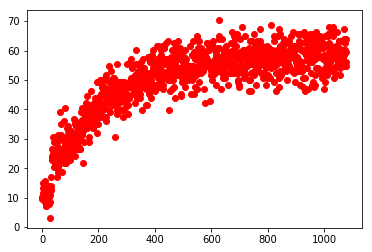

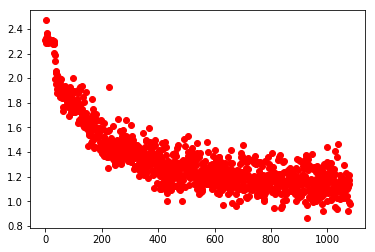

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

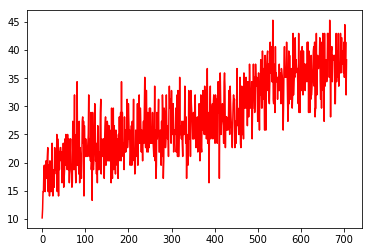

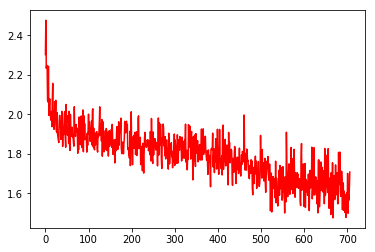

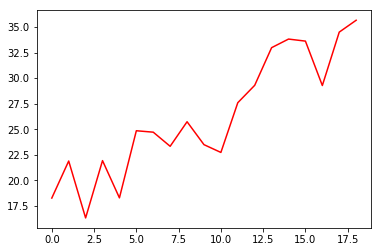

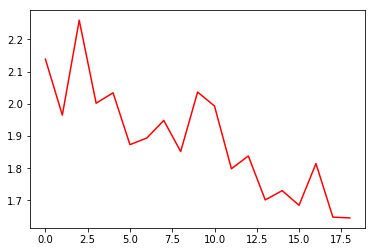

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()